In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import random
import keras
%matplotlib inline

Using TensorFlow backend.


# 1/ Explore data

In [2]:
val_dir = 'data/validation'
val_data = glob.glob(val_dir + "/**/*.jpg")

train_dir = 'data/train'
train_data = glob.glob(train_dir + "/**/*.jpg")

print("Train data: {}\nValidation data: {}".format(len(train_data), len(val_data)))

Train data: 31613
Validation data: 1302


Image YCrCb format - min: 2, max: 245, mean: 110.16753641764323


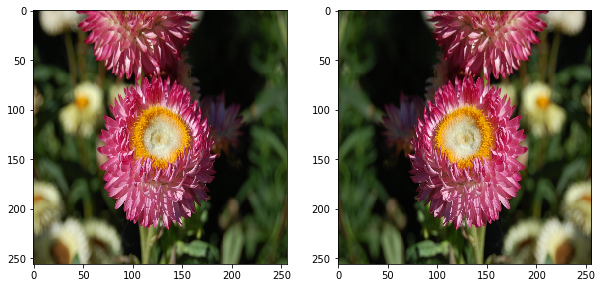

In [3]:
# Load an image
sample = random.choice(train_data)
img_BGR = cv2.imread(sample)
img_BGR = cv2.resize(img_BGR, (256, 256))
img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)

# Show statistics
print("Image YCrCb format - min: {}, max: {}, mean: {}".format(img_YCrCb.min(), img_YCrCb.max(), img_YCrCb.mean()))

# Augmented operations - display original and flipped versions
img_YCrCb_flip = cv2.flip(img_YCrCb, 1)
plt.figure(figsize = (10, 10))
plt.subplot(121).imshow(cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB))
plt.subplot(122).imshow(cv2.cvtColor(img_YCrCb_flip, cv2.COLOR_YCrCb2RGB))

In [4]:
# Analyze YCrCb space vs Gray

img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
img_Gray_BGR = cv2.cvtColor(img_Gray, cv2.COLOR_GRAY2BGR)
img_Gray_YCrCb = cv2.cvtColor(img_Gray_BGR, cv2.COLOR_BGR2YCrCb)
img_Gray_RGB = cv2.cvtColor(img_Gray, cv2.COLOR_GRAY2RGB)

diff_Y = abs(img_YCrCb[...,0] - img_Gray_YCrCb[...,0])
diff_Cr = abs(img_YCrCb[...,1] - img_Gray_YCrCb[...,1])
diff_Cb = abs(img_YCrCb[...,2] - img_Gray_YCrCb[...,2])

print('Max difference between YCrCb channels of original image and gray image:')
print('- Y: {}\n- Cr: {}\n- Cb: {}\n'.format(diff_Y.max(), diff_Cr.max(), diff_Cb.max()))

print('Range value (max - min) for each channel of gray image:')
print('- Y: {}\n- Cr: {}\n- Cb: {}'.format(img_Gray_YCrCb[...,0].max() - img_Gray_YCrCb[...,0].min(),
                                           img_Gray_YCrCb[...,1].max() - img_Gray_YCrCb[...,1].min(),
                                           img_Gray_YCrCb[...,2].max() - img_Gray_YCrCb[...,2].min()))

Max difference between YCrCb channels of original image and gray image:
- Y: 0
- Cr: 255
- Cb: 255

Range value (max - min) for each channel of gray image:
- Y: 243
- Cr: 0
- Cb: 0


We can conclude the following regarding YCrCb space:

- The Y channel of an image and its black & white version are identical;
- The entire information of a black & white image is in the Y channel of its YCrCb color space.

It let us decide to use the following strategy for converting black & white images to color:
- convert to YCrCb space ;
- keep the Y channel as is (since it does not change between color and black & white versions) ;
- use only the Y channel (which contains all information of a gray image) to predict Cr & Cb channels.

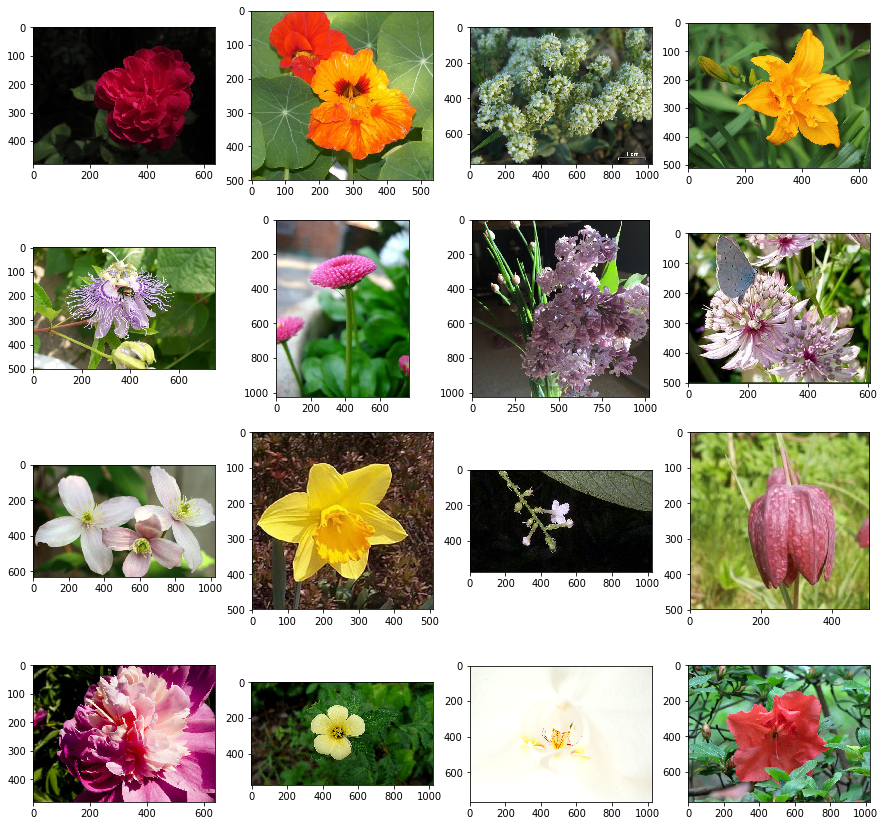

In [5]:
# Display sample images

lines, columns = 4, 4
_, axs = plt.subplots(lines, columns, figsize=(15, 15))
for i in range(lines):
    for j in range(columns):
        img=mpimg.imread(random.choice(train_data))
        axs[i, j].imshow(img)

# 2/ Evaluate predictions

In [6]:
# Load model
model_path = "model/0uiwhl8e.073.h5"
width, height = 256, 256
model = keras.models.load_model(model_path)

In [7]:
# Load sample images
test_data = val_data

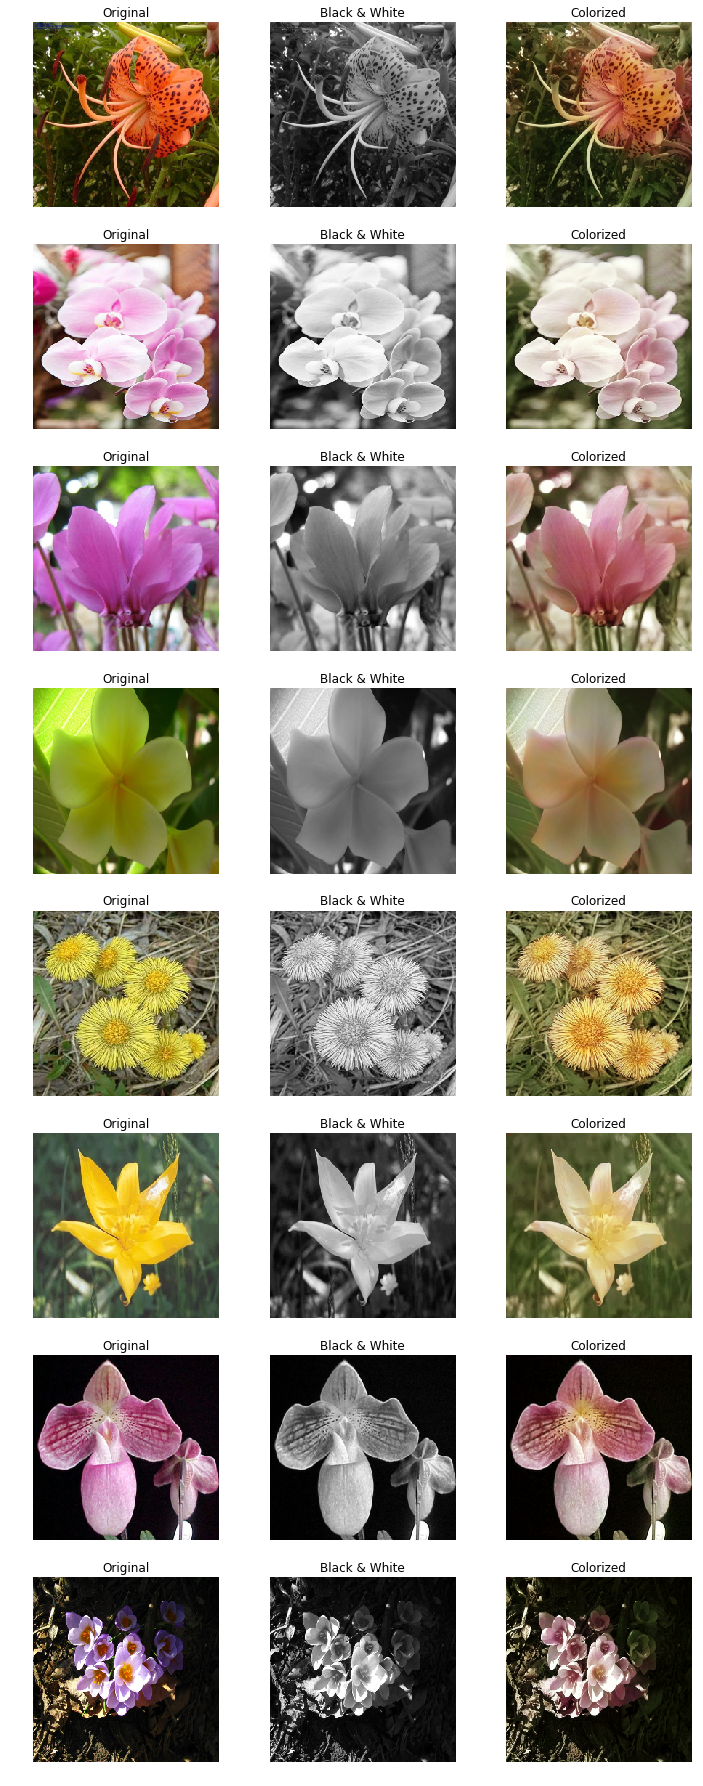

In [8]:
lines, columns = 8, 3
_, axs = plt.subplots(lines, columns, figsize=(columns * 4, lines * 4))

for i in range(lines):
        
    img_path = random.choice(test_data)

    # Read and resize image
    img_BGR = cv2.imread(img_path)
    img_BGR = cv2.resize(img_BGR, (width, height))
    img_original = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

    # Convert to gray
    img_gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
    img_input = img_gray
    img_gray = img_gray.reshape((1,width,height))

    # Preprocess image
    img_gray = img_gray / 127.5 - 1

    # Predict CrCb channels
    img_CrCb = model.predict(img_gray)[0]

    # Reconstitute image
    img_gray = img_gray[0]
    img_YCrCb = np.dstack((img_gray, img_CrCb))
    img_YCrCb = (img_YCrCb + 1) * 127.5
    img_YCrCb = img_YCrCb.astype(np.uint8)

    # Convert to RGB
    img_output = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
    
    # Display images
    axs[i, 0].imshow(img_original)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original')
    axs[i, 1].imshow(img_gray, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Black & White')
    axs[i, 2].imshow(img_output)
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Colorized')